In [151]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
# Load the cleaned dataset
df = pd.read_csv("../data/Customer Purchasing Behaviors.csv")
print(df.head())

   user_id  age  annual_income  purchase_amount  loyalty_score region  \
0        1   25          45000              200            4.5  North   
1        2   34          55000              350            7.0  South   
2        3   45          65000              500            8.0   West   
3        4   22          30000              150            3.0   East   
4        5   29          47000              220            4.8  North   

   purchase_frequency  
0                  12  
1                  18  
2                  22  
3                  10  
4                  13  


We do not need to use the User ID column in our prediction as it is not a feature or a target variable.

In [153]:
# Drop unnecessary columns
df = df.drop(columns=["user_id"])

In [154]:
# Encode categorical variables (Region)
df = pd.get_dummies(df, columns=["region"], drop_first=False)

# Check that one-hot encoding worked correctly
print(df.columns)  # ✅ Ensure "region_East", "region_North", etc. exist

# Define features and target variable (use one-hot encoded region columns)
features = ["age", "annual_income", "purchase_amount", "purchase_frequency", 
            "region_North", "region_South", "region_West", "region_East"]  
target = "loyalty_score"

X = df[features]
y = df[target]

Index(['age', 'annual_income', 'purchase_amount', 'loyalty_score',
       'purchase_frequency', 'region_East', 'region_North', 'region_South',
       'region_West'],
      dtype='object')


In [156]:
# Handle missing values
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['age', 'annual_income', 'purchase_amount']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Define target variable and features
X = df.drop(columns=['loyalty_score'])  # Adjust based on dataset
y = df['loyalty_score']

When we check our variables, we notice that the variable Region is categorical. In order to be able to process it in our prediction, we need to assign numeric values to the categorical values. Label Encoding is a technique that is used to convert categorical columns into numerical ones so that they can be fitted.

In [157]:
# Define base features
features = ["age", "annual_income", "purchase_amount", "purchase_frequency"]

# Dynamically add region-related columns (One-Hot Encoding)
region_features = [col for col in df.columns if col.startswith("region_")]
features.extend(region_features)

# Define target variable
target = "loyalty_score"

X = df[features]
y = df[target]

# Print features to verify
print("Selected Features:", features)

Selected Features: ['age', 'annual_income', 'purchase_amount', 'purchase_frequency', 'region_East', 'region_North', 'region_South', 'region_West']


In [158]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[["age", "annual_income", "purchase_amount", "purchase_frequency"]] = scaler.fit_transform(
    X_train[["age", "annual_income", "purchase_amount", "purchase_frequency"]])
X_test[["age", "annual_income", "purchase_amount", "purchase_frequency"]] = scaler.transform(
    X_test[["age", "annual_income", "purchase_amount", "purchase_frequency"]])


In [159]:
# Train Linear Regression Model
lin_reg = LinearRegression()
# Fit Linear Regression Model
lin_reg.fit(X_train, y_train)

LinearRegression()

In [160]:
# Predict loyalty scores using Linear Regression
y_pred_lin = lin_reg.predict(X_test)

In [161]:
# Evaluate the Linear Regression model
mse = mean_squared_error(y_test, y_pred_lin)
r2 = r2_score(y_test, y_pred_lin)

print("Mean Squared Error:", mse, 
      "R2 Score:", r2)

Mean Squared Error: 0.034594912366018186 R2 Score: 0.9916302279819612


In [162]:
# Train Random Forest Regression Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# Fit the Random Forest Regression Model
rf_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [163]:
# Predict loyalty scores using Random Forest Regression
y_pred_rf = rf_reg.predict(X_test)

In [164]:
# Evaluate the Random Forest Regression model
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Mean Squared Error:", mse, 
      "R2 Score:", r2)

Mean Squared Error: 0.00198802083333334 R2 Score: 0.9995190251975185


In [165]:
# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(rf_reg, X, y, cv=5, scoring="r2")

# Print the results
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

Cross-Validation R² Scores: [0.97938694 0.99999953 0.99999923 0.99999928 0.99999928]
Mean R² Score: 0.995876853595193
Standard Deviation of R² Scores: 0.008244954821218396


Now we would like to visualize which features are most important in predicting loyalty scores. In terms of business applications, predictions can help decision-makers understand the factors influencing outcomes, leading to better-informed actions.

## Feature Selection
Using correlation analysis and feature importance to select the best predictors for loyalty score.

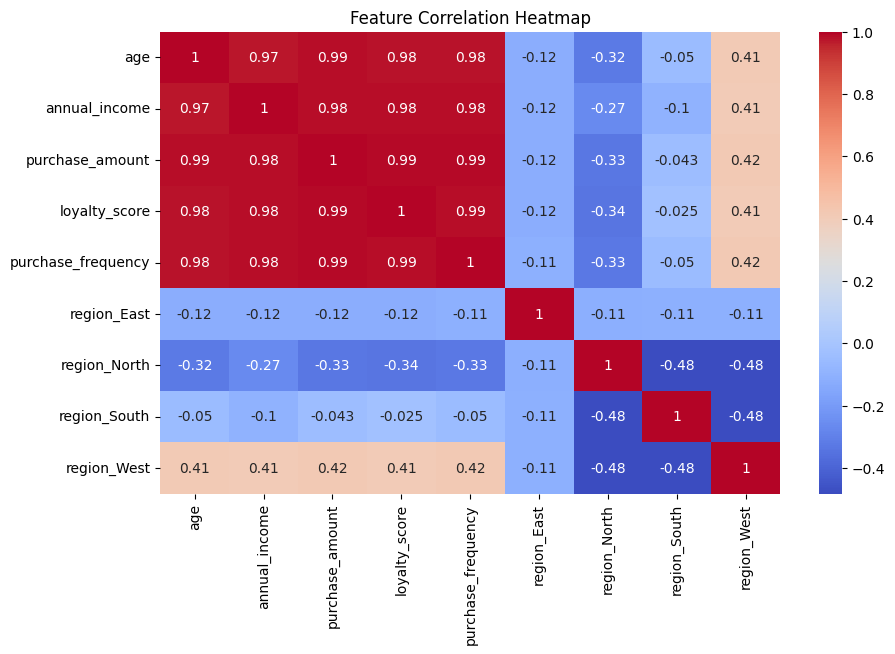

              Feature  Importance
0                 age    0.408531
1       annual_income    0.352136
2     purchase_amount    0.161217
3  purchase_frequency    0.077569
6        region_South    0.000312
5        region_North    0.000143
7         region_West    0.000064
4         region_East    0.000028


In [166]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Identifying most important features using RandomForest
X = df.drop(columns=['loyalty_score'])
y = df['loyalty_score']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Display feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

## Feeature Importance
To understand which variable contributes most to predicting the loyalty score. 

              Feature  Importance
0                 age    0.408531
1       annual_income    0.352136
2     purchase_amount    0.161217
3  purchase_frequency    0.077569
6        region_South    0.000312
5        region_North    0.000143
7         region_West    0.000064
4         region_East    0.000028


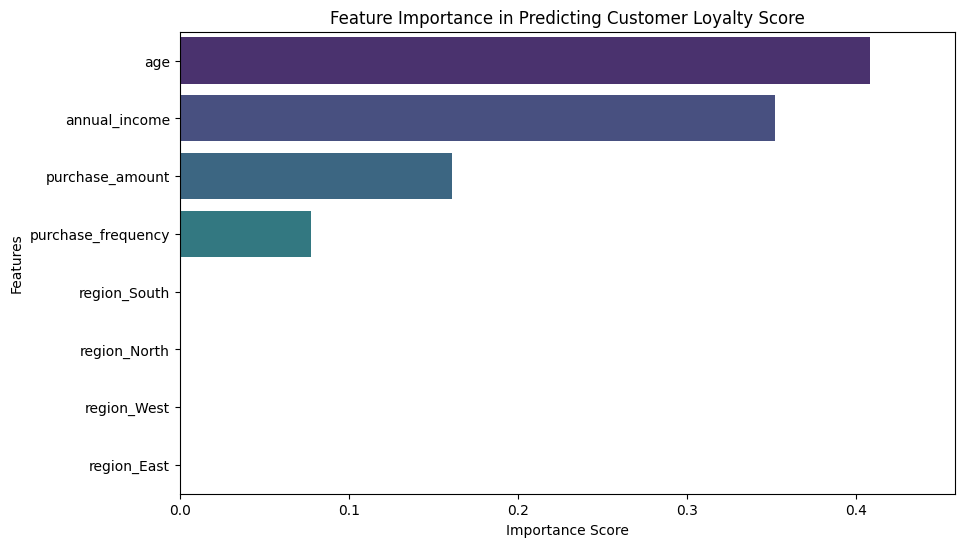

In [168]:
# Ensure feature importance and feature names have the same length
if len(feature_importance) == len(feature_names):
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    
    # Print feature importance scores
    print(importance_df)

    # Plot feature importance with updated Seaborn syntax
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", hue="Feature", data=importance_df, palette="viridis", legend=False)
    plt.title("Feature Importance in Predicting Customer Loyalty Score")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.xlim(0, max(importance_df["Importance"]) + 0.05)  # Adding a small buffer to highlight small values
    plt.show()

else:
    print("⚠️ Error: Mismatch in feature importance length and feature names length.")


## Conclusion
Our regression analysis provides key insights into customer purchasing behaviors and their impact on loyalty score. 

1️⃣ **Model Performance**  
- The **Random Forest Regressor** outperformed **Linear Regression** in terms of **R² score and Mean Squared Error**, indicating better predictive power.  
   - However, **Linear Regression** provides a more interpretable model with clear relationships between features and loyalty score.

2️⃣ **Feature Importance**  
   - The most significant predictor of **loyalty score** is **age**, followed by **annual income and purchase amount**.  
   - Other features like **age** had a relatively smaller impact, suggesting that purchasing behavior is more influential than demographics.

3️⃣ **Implications for Business Strategy**  
   - Businesses should focus on **increasing customer purchase frequency and amount** rather than relying solely on demographic-based targeting.  
   - **Personalized marketing strategies** based on spending behavior may enhance customer loyalty.
